In [22]:
import sys
KITTI_ROOT_PATH = '/home/ruizhu/Documents/Datasets/kitti'
sys.path.append(KITTI_ROOT_PATH+'/kitti-lidar-utils')
sys.path.append(KITTI_ROOT_PATH+'/kitti-lidar-utils/source')
sys.path.append(KITTI_ROOT_PATH+'/depth/devkit/python')

import numpy as np
np.set_printoptions(precision=4, suppress=True)

%reload_ext autoreload
%autoreload 2

from scipy.io import savemat
import itertools
import pdb
import os
from PIL import Image, ImageOps
import imageio
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
from source.utils import load_tracklets_for_frames, point_inside, in_hull
from source import parseTrackletXML as xmlParser
from source.kitti_util import *
import argparse
from matplotlib import cm
from math import atan2, degrees
from PIL import Image
from read_depth import *
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import torch

import dsac_tools.utils_F as utils_F
import dsac_tools.utils_geo as utils_geo
import dsac_tools.utils_misc as utils_misc
import dsac_tools.utils_vis as utils_vis
import dsac_tools.utils_opencv as utils_opencv
from dsac_tools.H_loss import HLoss
from dsac_tools.dsac import DSAC

from kitti_tools.utils_kitti import *
kitti_two_frame_loader = KittiLoader(KITTI_ROOT_PATH)

## Select sequence
date_name = '2011_09_26'
seq_name = '_drive_0005_sync'

kitti_two_frame_loader.set_drive(date_name, seq_name)
kitti_two_frame_loader.load_cam_poses()
# kitti_two_frame_loader.show_demo()
kitti_two_frame_loader.get_left_right_gt()
kitti_two_frame_loader.rectify_all(visualize=False)

## Help functions and plot params
fig_scale = 300
fig_ratio = [4, 3]
im_shape = kitti_two_frame_loader.im_shape

KITTI track loaded at /home/ruizhu/Documents/Datasets/kitti/raw/2011_09_26/2011_09_26_drive_0005_sync/.
Scene pose loaded. First two poses:
[array([[ 1., -0.,  0., -0.],
       [ 0.,  1., -0.,  0.],
       [ 0., -0.,  1.,  0.]]), array([[ 0.9999,  0.0005,  0.0157,  0.0088],
       [-0.0005,  1.    , -0.0046,  0.0056],
       [-0.0157,  0.0046,  0.9999, -0.3428]])]
[[721.5377   0.     609.5593  44.8573]
 [  0.     721.5377 172.854    0.2164]
 [  0.       0.       1.       0.0027]]
[[ 721.5377    0.      609.5593 -339.5242]
 [   0.      721.5377  172.854     2.1999]
 [   0.        0.        1.        0.0027]]
GT camera for left/right.
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 0.0598]
 [-0.0004]
 [ 0.0027]]
[[-0.4729]
 [ 0.0024]
 [ 0.0027]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [[-0.5327]
 [ 0.0028]
 [-0.    ]]
Finished rectifying all frames.


## Get two frames

-- delta_Rtij_gt [[ 0.9992 -0.0021  0.0404 -0.0269]
 [ 0.0031  0.9997 -0.0235  0.0465]
 [-0.0403  0.0236  0.9989 -0.9918]]
-- E_gt [[ 0.0012  0.9926  0.0232]
 [-0.9921  0.0027 -0.0132]
 [-0.0466 -0.0268 -0.0012]]
# kps: 3420, descriptors: (3420, 128)
# kps: 3421, descriptors: (3421, 128)
# good points:  609


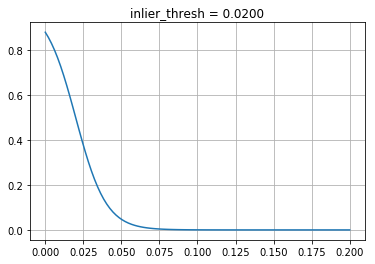

In [ ]:
%reload_ext autoreload
%autoreload 2
i = 0
j = 3

# Get two frames
X_rect_i, X_rect_i_vis, delta_Rtij = kitti_two_frame_loader.get_ij(i, j, visualize=False)
print('-- delta_Rtij_gt', delta_Rtij)
E_gt_th, F_gt_th = utils_F._E_F_from_Rt(delta_Rtij[:, :3], delta_Rtij[:, 3:4], kitti_two_frame_loader.K)    
F_gt = F_gt_th.numpy()
R2s, t2s, M2s = utils_F._get_M2s(E_gt_th)
print('-- E_gt', E_gt_th.numpy())

img1_rgb, img2_rgb = kitti_two_frame_loader.dataset_rgb[i][0], kitti_two_frame_loader.dataset_rgb[j][0]
img1_rgb_np, img2_rgb_np = np.array(img1_rgb), np.array(img2_rgb)
img1, img2 = utils_opencv.PIL_to_gray(img1_rgb), utils_opencv.PIL_to_gray(img2_rgb)

# Keypoint detection and matching with SIFT
x1_all, kp1, des1 = utils_opencv.SIFT_det(img1, img1_rgb, visualize=False)
x2_all, kp2, des2 = utils_opencv.SIFT_det(img2, img2_rgb, visualize=False)
x1, x2 = utils_opencv.KNN_match(des1, des2, x1_all, x2_all, kp1, kp2, img1_rgb, img2_rgb, visualize=False)

# Sample and check
random_idx, x1_sample, x2_sample = utils_opencv.sample_and_check(x1, x2, img1_rgb, img2_rgb, img1_rgb_np, img2_rgb_np, F_gt, kitti_two_frame_loader, visualize=False)

# DSAC
DSAC_params = {}
DSAC_params['inlier_beta'] = 100
DSAC_params['inlier_thresh'] = 0.02 # HOW TO SET THRES?
DSAC_params['N_hypotheses'] = 10000
DSAC_params['inlier_alpha'] = 0.5

## Visualize soft-inlier counting function
a = torch.linspace(0, DSAC_params['inlier_thresh']*10, 100)
b = 1 - torch.sigmoid(DSAC_params['inlier_beta'] * (a - DSAC_params['inlier_thresh']))
plt.plot(a.numpy(), b.numpy())
plt.grid()
plt.title('inlier_thresh = %.4f'%DSAC_params['inlier_thresh'])
plt.show()

## Validate pose estimation with best 10
# utils_F.vali_with_best10(F_gt_th, E_gt_th, x1, x2, img1_rgb_np, img2_rgb_np, kitti_two_frame_loader, DSAC_params)

## Set up DSAC
loss = HLoss()
dsac = DSAC(DSAC_params['N_hypotheses'], DSAC_params['inlier_thresh'], DSAC_params['inlier_beta'], DSAC_params['inlier_alpha'], loss)
N_scores = dsac(torch.from_numpy(x1), torch.from_numpy(x2), F_gt_th)
N_scores_np = N_scores.numpy()
N_scores_np = N_scores_np/np.max(N_scores_np)

utils_vis.draw_corr_widths(img1_rgb_np, img2_rgb_np, x1_sample, x2_sample, N_scores_np[random_idx]*10+1, 'Soft-inlier scores w.r.t. estimated F (the thicker the better corres.)', False)

F_est_th = dsac.best_H
best_corres_idx = dsac.best_corres_idx
print('-- F_est & F_gt', (F_est_th / torch.norm(F_est_th) * torch.norm(F_gt_th)).numpy())
print(F_gt)

E_est_th = utils_F._F_to_E(F_est_th, kitti_two_frame_loader.K_th)
print('-- E_est & E_gt', (E_est_th / torch.norm(E_est_th) * torch.norm(E_gt_th)).numpy())
print(E_gt_th.numpy())

## Recover [R|t]
inlier_dists = dsac.sampson_dists.numpy()[dsac.best_H_idx, :]
inlier_mask = inlier_dists < inlier_thresh
M2_list = utils_F._E_to_M(E_est_th, kitti_two_frame_loader.K, x1, x2, inlier_mask, delta_Rtij[:, :3], delta_Rtij[:, 3:4])

# [TODO] Check issues: outliers!

In [67]:
R2s, t2s, M2s = utils_F._get_M2s(E_est_th)

R1 = np.eye(3)
t1 = np.zeros((3, 1))
M1 = np.hstack((R1, t1))

cheirality_checks = []
M2_list = []
# for Rt_idx, M2 in enumerate(M2s):
Rt_idx = 1
M2 = M2s[Rt_idx].numpy()
R2 = M2[:, :3]
t2 = M2[:, 3:4]
print(M2, np.linalg.det(R2))

X_tri_homo = cv2.triangulatePoints(np.matmul(kitti_two_frame_loader.K, M1), np.matmul(kitti_two_frame_loader.K, M2), x1[inlier_mask].T, x2[inlier_mask].T)
X_tri = X_tri_homo[:3, :]/X_tri_homo[-1, :]
C1 = -np.matmul(R1, t1) # https://math.stackexchange.com/questions/82602/how-to-find-camera-position-and-rotation-from-a-4x4-matrix
cheirality1 = np.matmul(R1[2:3, :], (X_tri-C1)) # https://cmsc426.github.io/sfm/

X_tri_cam3 = np.matmul(R2, X_tri) + t2
C2 = -np.matmul(R2, t2)
cheirality2 = np.matmul(R2[2:3, :], (X_tri_cam3-C2))

print(cheirality1)
print(cheirality2)

#     cheirality_check = np.min(cheirality1)>0 and np.min(cheirality2)>0
#     cheirality_checks.append(cheirality_check)
#     if cheirality_check:
#         print(M2)
#         M2_list.append(M2)
#         print(X_tri[-1, :])
#         print(X_tri_cam3[-1, :])

outlier = cheirality2<0
print(outlier)

[[-0.997   0.0021 -0.0779  0.0189]
 [-0.0004 -0.9998 -0.022   0.0227]
 [-0.0779 -0.0219  0.9967 -0.9996]] 1.0
[[0.4828 0.4832 0.5158 0.5158 0.5162 0.5164 0.4881 0.4881 0.4882 0.518
  0.487  0.4869 0.5179 0.5179 0.4861 0.4896 0.4899 0.4897 0.4897 0.4894
  0.4895 0.4895 0.5077 0.4897 0.49   0.4895 0.5062 0.4899 0.5058 0.5058
  0.4898 0.4899 0.4897 0.4891 0.4891 0.4895 0.4898 0.4884 0.4899 0.4896
  0.4903 0.4903 0.4899 0.4891 0.4892 0.4899 0.4899 0.4898 0.4897 0.4899
  0.491  0.4894 0.4911 0.5185 0.4908 0.4904 0.4905 0.4907 0.4907 0.4909
  0.491  0.4889 0.4896 0.4896 0.4901 0.491  0.489  0.5184 0.4908 0.4893
  0.4895 0.4892 0.4899 0.4911 0.4892 0.4893 0.489  0.4913 0.4913 0.4902
  0.4894 0.4912 0.4897 0.4895 0.4895 0.4895 0.4898 0.4898 0.4897 0.4926
  0.4899 0.4896 0.4899 0.4915 0.4904 0.4899 0.4917 0.4898 0.4902 0.4901
  0.4912 0.4912 0.4903 0.4914 0.49   0.4913 0.4917 0.4907 0.4909 0.4903
  0.4919 0.4922 0.4904 0.491  0.491  0.4923 0.4922 0.4911 0.4921 0.4909
  0.4917 0.4922 0.4926 0.49

In [342]:
print(M2)
print(delta_Rtij)
print(utils_geo.rot12_to_angle_error(M2[:, :3],  delta_Rtij[:, :3]))

[[ 0.9992 -0.0025  0.0396  0.031 ]
 [ 0.0034  0.9997 -0.0233  0.0221]
 [-0.0395  0.0234  0.9989 -0.9993]]
[[ 0.9992 -0.0021  0.0404 -0.0269]
 [ 0.0031  0.9997 -0.0235  0.0465]
 [-0.0403  0.0236  0.9989 -0.9918]]
0.051731531391599944


(1, 219)
[0.0003 0.001 ]


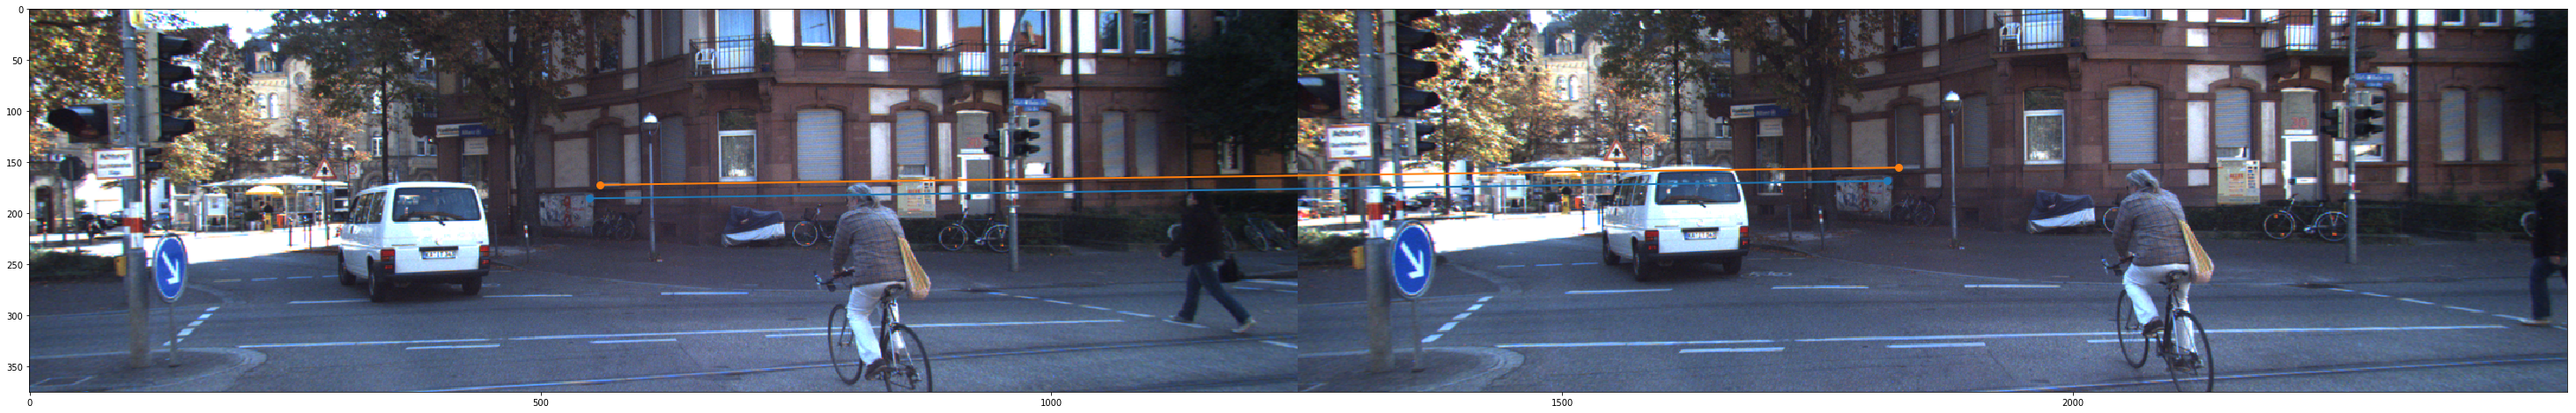

tensor([0.0275, 0.0315], dtype=torch.float64)
tensor([0.0003, 0.0010], dtype=torch.float64)
[[-12.0408 -50.8178]
 [  2.3738  -0.8336]
 [139.5749 711.8337]]
[[   9.1045    5.1531]
 [  -1.8091    0.0924]
 [-105.6248  -72.5481]]


In [351]:
outlier = cheirality2<0
print(cheirality2.shape)
o = outlier.reshape([-1])
print(inlier_dists[inlier_mask][o])
x1_outlier = x1[inlier_mask, :][o]
x2_outlier = x2[inlier_mask, :][o]
utils_vis.draw_corr_widths(img1_rgb_np, img2_rgb_np, x1_outlier, x2_outlier, np.zeros(o.shape[0])+2, '', False)

dist_gtF = utils_F._sampson_dist(F_gt_th, torch.from_numpy(x1_outlier), torch.from_numpy(x2_outlier))
print(dist_gtF)
est_gtF = utils_F._sampson_dist(F_est_th, torch.from_numpy(x1_outlier), torch.from_numpy(x2_outlier))
print(est_gtF)

X_tri_homo = cv2.triangulatePoints(np.matmul(kitti_two_frame_loader.K, M1), np.matmul(kitti_two_frame_loader.K, delta_Rtij), x1_outlier.T, x2_outlier.T)
X_tri = X_tri_homo[:3, :]/X_tri_homo[-1, :]
print(X_tri)
X_tri_homo = cv2.triangulatePoints(np.matmul(kitti_two_frame_loader.K, M1), np.matmul(kitti_two_frame_loader.K, M2), x1_outlier.T, x2_outlier.T)
X_tri = X_tri_homo[:3, :]/X_tri_homo[-1, :]
print(X_tri)

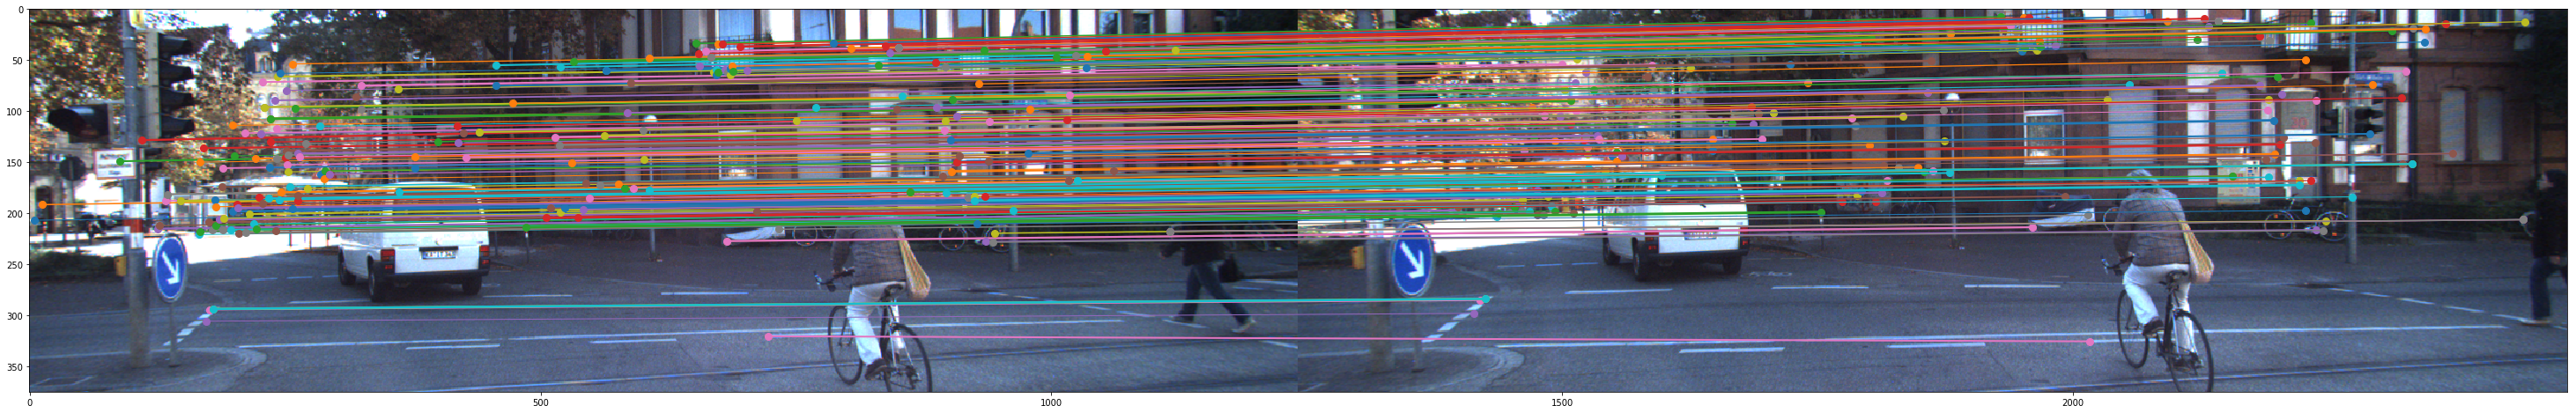

In [362]:
# utils_vis.draw_corr_widths(img1_rgb_np, img2_rgb_np, x1, x2, np.zeros(x1.shape[0]), '', False)
w = inlier_dists[inlier_mask]
w = w/np.max(w)*2+1
utils_vis.draw_corr_widths(img1_rgb_np, img2_rgb_np, x1[inlier_mask], x2[inlier_mask], w, '', False)

# With SuperPoint corres.

In [79]:
sp_results = np.load('dsac_tools/data/0000000000.npz')
print(x.files)
x1_sp = sp_results['keypoints1']
x2_sp = sp_results['keypoints2']
maches_sp = sp_results['matches']
x1 = maches_sp[:, :2]
x2 = maches_sp[:, 2:4]
print(x1_sp.shape, x2_sp.shape, maches_sp.shape)
print(x1.shape, x2.shape)

draw_corr_widths(img1_rgb, img2_rgb, x1, x2, np.zeros(x1.shape[0])+3, 'SuperPoint detection and correspondence', rescale=False)

errors = utils_F._sampson_dist(F_gt_th, torch.from_numpy(x1).to(torch.float64), torch.from_numpy(x2).to(torch.float64), False)
sort_index = np.argsort(errors.numpy())
mask_index = sort_index[:10]
print(errors[sort_index].numpy())

E_est_th = utils_F.E_from_XY(torch.from_numpy(x1[mask_index, :]), torch.from_numpy(x2[mask_index, :]))
print(E_gt_th.numpy())
print((E_est_th / torch.norm(E_est_th) * torch.norm(E_gt_th)).numpy())
R2s, t2s, M2s = utils_F._get_M2s(E_est_th)
print(M2s[0].numpy())

error_R = min([utils_F.rot12_to_angle_error(R2.numpy(), delta_R_gt) for R2 in R2s])
print('The rotation error of best 10 corres. w.r.t GT F (degree): ', error_R)

NameError: name 'x' is not defined

In [ ]:
%reload_ext autoreload
%autoreload 2

from dsac_tools.H_loss import HLoss
from dsac_tools.dsac import DSAC
import dsac_tools.utils_F as utils_F
import torch

N_hypotheses = 10000
inlierthreshold = 0.05
inlierbeta = 100.
inlieralpha = 0.5

loss = HLoss()
dsac = DSAC(N_hypotheses, inlierthreshold, inlierbeta, inlieralpha, loss)
N_scores = dsac(torch.from_numpy(x1), torch.from_numpy(x2), F_gt_th)
N_scores_np = N_scores.numpy()
N_scores_np = N_scores_np/np.max(N_scores_np)

draw_corr_widths(img1_rgb, img2_rgb, x1, x2, N_scores_np*5, 'Soft-inlier scores w.r.t. estimated F (the thicker the better corres.)', False)

F_est_th = dsac.best_H
best_corres_idx = dsac.best_corres_idx
# print((F_est_th / torch.norm(F_est_th) * torch.norm(F_gt_th)).numpy())
# print(F_gt)

E_est_th = utils_F._F_to_E(F_est_th, K_th)
print((E_est_th / torch.norm(E_est_th) * torch.norm(E_gt_th)).numpy())
print(E_gt_th.numpy())

R2s, t2s, M2s = utils_F._get_M2s(E_est_th)
# print([M2.numpy() for M2 in M2s])

R1 = np.eye(3)
t1 = np.zeros((3, 1))
M1 = np.hstack((R1, t1))

cheirality_checks = []
for Rt_idx, M2 in enumerate(M2s):
    M2 = M2.numpy()
    R2 = M2[:, :3]
    t2 = M2[:, 3:4]
    
    X_tri_homo = cv2.triangulatePoints(np.matmul(K, M1), np.matmul(K, M2), x1[best_corres_idx, :].T, x2[best_corres_idx, :].T)
    X_tri = X_tri_homo[:3, :]/X_tri_homo[-1, :]
    cheirality1 = np.matmul(R1[2:3, :], (X_tri-t1))
    
    X_tri_cam3 = np.matmul(R2, X_tri) + t2
    cheirality2 = np.matmul(R2[2:3, :], (X_tri-t2))
    cheirality_checks.append(np.min(cheirality1)>0 and np.min(cheirality2)>0)
    
    print('===========')
    print(M2)
    print('-----')
    print(cheirality1)
    print('-----')
    print(cheirality2)

if np.sum(cheirality_checks)==1:
    Rt_idx = cheirality_checks.index(True)
    print('The %d_th Rt meets the Cheirality Condition! with [R|t]:'%Rt_idx)
    print(M2s[Rt_idx].numpy())
else:
    print('Error! %d of qualified [R|t] found!'%np.sum(cheirality_checks))

error_R = min([utils_F.rot12_to_angle_error(R2.numpy(), delta_R_gt) for R2 in R2s])
print('The rotation error from RANSAC (degree): ', error_R)